Example of script to make a violin plot of number of UMI per spot.<br>

Input files are downsampled.<br>

data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/<br>
please download:<br>
10005CN48_C1_downsamp.tsv <br>
10005CN48_D1_downsamp.tsv <br>
10005CN48_E1_downsamp.tsv <br>
10015CN60_E2_downsamp.tsv <br>
10015CN84_C2_downsamp.tsv <br>
10015CN84_D2_downsamp.tsv <br>
10005CN48_C1_stdata_under_tissue_IDs.txt <br>
10005CN48_D1_stdata_under_tissue_IDs.txt <br>
10005CN48_E1_stdata_under_tissue_IDs.txt <br>
10015CN60_E2_stdata_under_tissue_IDs.txt <br>
10015CN84_C2_stdata_under_tissue_IDs.txt <br>
10015CN84_D2_stdata_under_tissue_IDs.txt<br>

In [2]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import matplotlib as mpl
import statistics
import statsmodels.api as sm
import matplotlib.patches as mpatches
from mlxtend.evaluate import permutation_test

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from matplotlib.text import Text
from matplotlib import transforms, lines
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
from seaborn.utils import remove_na

from scipy import stats
DEFAULT = object()


def stat_test(box_data1, box_data2, test):
    test_short_name = ''
    formatted_output = None
    
    if test == 'Wilcoxon':
        u_stat, pval = stats.ranksums(box_data1, box_data2, nan_policy= 'omit')
        test_short_name = 'Wilcox'
        formatted_output = ("Wilcoxon test P_val={:.3e} U_stat={:.3e}"
                           .format(pval, u_stat))
        
    if test == 'ttest':
        pval = stats.ttest_ind(box_data1, box_data2, equal_var=False)
        test_short_name = 'T-test'
        formatted_output = ("T-test P_val={:.3e} "
                           .format(pval))
    
    if test == 'Perm-test-mc': #two-sided perm test
        pval = exact_mc_perm_test(box_data1, box_data2, 10000)
        u_stat = 10000
        test_short_name = 'Perm-test'
        formatted_output = ("Perm-test P_val={:.3e} "
                           .format(pval))   
    if test == 'Perm-test': #one-sided perm test
        pval = permutation_test(box_data1, box_data2,
                                func='x_mean > y_mean',
                           method='approximate',
                           num_rounds=10000,
                           seed=0) 
        u_stat = 10000
        test_short_name = 'Perm-test'
        formatted_output = ("Perm-test P_val={:.3e} "
                           .format(pval))       
       

    return pval, u_stat, formatted_output, test_short_name

def exact_mc_perm_test(xs, ys, nmc):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.shuffle(zs)
        k += diff <= np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc

def pval_annotation_text(x, pvalue_thresholds):
    singleValue = False
    if type(x) is np.array:
        x1 = x
    else:
        x1 = np.array([x])
        singleValue = True
    # Sort the threshold array
    pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
    x_annot = pd.Series(["" for _ in range(len(x1))])
    for i in range(0, len(pvalue_thresholds)):
        if (i < len(pvalue_thresholds)-1):
            condition = (x1 <= pvalue_thresholds[i][0]) & (pvalue_thresholds[i+1][0] < x1)
            x_annot[condition] = pvalue_thresholds[i][1]
        else:
            condition = x1 < pvalue_thresholds[i][0]
            x_annot[condition] = pvalue_thresholds[i][1]

    return x_annot if not singleValue else x_annot.iloc[0]


def simple_text(pval, pvalue_format, pvalue_thresholds, test_short_name=None):
    """
    Generates simple text for test name and pvalue
    :param pval: pvalue
    :param pvalue_format: format string for pvalue
    :param test_short_name: Short name of test to show
    :param pvalue_thresholds: String to display per pvalue range
    :return: simple annotation
    """
    # Sort thresholds
    thresholds = sorted(pvalue_thresholds, key=lambda x: x[0])

    # Test name if passed
    text = test_short_name and test_short_name + " " or ""

    for threshold in thresholds:
        if pval < threshold[0]:
            pval_text = "p ≤ {}".format(threshold[1])
            break
    else:
        pval_text = "p = {}".format(pvalue_format).format(pval)

    #return text + pval_text
    return pval_text


def add_stat_annotation(ax,
                        data=None, x=None, y=None, hue=None, order=None, hue_order=None,
                        box_pairs=None,
                        test='Wilcoxon', text_format='star', pvalue_format_string=DEFAULT,
                        loc='inside', show_test_name=True, pvalue_thresholds=DEFAULT,
                        use_fixed_offset=False, line_offset_to_box=None, line_offset=None,
                        line_height=0.02, text_offset=1, stack=True,
                        color='0.2', linewidth=1.5, fontsize='medium', verbose=1):
    """
    User should use the same argument for the data, x, y, hue, order, hue_order as the seaborn boxplot function.
    line_height is in axes fraction coordinates.
    text_offset is in points.
    box_pairs can be of either form:
    For non-grouped boxplot: [(cat1, cat2), (cat3, cat4)]
    For boxplot grouped by hue: [((cat1, hue1), (cat2, hue2)), ((cat3, hue3), (cat4, hue4))]
    Default pvalue_format_string is "{.3e}".
    pvalue_thresholds is a list of lists or tuples. Default is:
    For "star" text_format:
        [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]]
    For "simple" text_format :
        [[1e-5, "1e-5"], [1e-4, "1e-4"], [1e-3, "0.001"], [1e-2, "0.01"]]
    """

    def find_x_position_box(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        """
        if box_plotter.plot_hues is None:
            cat = boxName
            hueOffset = 0
        else:
            cat = boxName[0]
            hue = boxName[1]
            hueOffset = box_plotter.hue_offsets[box_plotter.hue_names.index(hue)]

        groupPos = box_plotter.group_names.index(cat)
        boxPos = groupPos + hueOffset
        return boxPos


    def get_box_data(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        Here we really have to duplicate seaborn code, because there is not direct access to the
        box_data in the BoxPlotter class.
        """
        if box_plotter.plot_hues is None:
            cat = boxName
        else:
            cat = boxName[0]
            hue = boxName[1]

        i = box_plotter.group_names.index(cat)
        group_data = box_plotter.plot_data[i]

        if box_plotter.plot_hues is None:
            # Draw a single box or a set of boxes
            # with a single level of grouping
            box_data = remove_na(group_data)
        else:
            hue_level = hue
            hue_mask = box_plotter.plot_hues[i] == hue_level
            box_data = remove_na(group_data[hue_mask])

        return box_data

    # Set default values if necessary
    if pvalue_format_string is DEFAULT:
        pvalue_format_string = '{:.3e}'
        simple_format_string = '{:.2f}'
    else:
        simple_format_string = pvalue_format_string

    if pvalue_thresholds is DEFAULT:
        if text_format == "star":
            pvalue_thresholds = [[1e-4, "****"], [1e-3, "***"],
                                 [1e-2, "**"], [0.05, "*"], [1, "ns"]]
        else:
            pvalue_thresholds = [[1e-5, "1e-5"], [1e-4, "1e-4"],
                                 [1e-3, "0.001"], [1e-2, "0.01"]]
    
    fig = plt.gcf()

    valid_list = ['inside', 'outside']
    if loc not in valid_list:
        raise ValueError("loc value should be one of the following: {}.".format(', '.join(valid_list)))
    valid_list = ['Wilcoxon', 'ttest','Perm-test','Perm-test-mc']
    if test not in valid_list:
        raise ValueError("test value should be one of the following: {}.".format(', '.join(valid_list)))

    if verbose >= 1 and text_format == 'star':
        print("pvalue annotation legend:")
        pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
        for i in range(0, len(pvalue_thresholds)):
            if (i < len(pvalue_thresholds)-1):
                print('{}: {:.2e} < p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i+1][0], pvalue_thresholds[i][0]))
            else:
                print('{}: p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i][0]))
        print()

    # Create the same BoxPlotter object as seaborn's boxplot
    box_plotter = sns.categorical._BoxPlotter(x, y, hue, data, order, hue_order,
                                              orient=None, width=.8, color=None, palette=None, saturation=.75,
                                              dodge=True, fliersize=5, linewidth=None)
    print(box_plotter.group_names, box_plotter.hue_names)
    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]

    if line_offset is None:
        if loc == 'inside':
            line_offset = 0.05
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset = 0.03
            line_offset_to_box = line_offset
    else:
        if loc == 'inside':
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset_to_box = line_offset
    y_offset = line_offset*yrange
    y_offset_to_box = line_offset_to_box*yrange

    y_stack = []
    annList = []
    test_result_list = []
    for box1, box2 in box_pairs:

        valid = None
        group_names = box_plotter.group_names
        hue_names = box_plotter.hue_names
        if box_plotter.plot_hues is None:
            cat1 = box1
            cat2 = box2
            hue1 = None
            hue2 = None
            label1 = '{}'.format(cat1)
            label2 = '{}'.format(cat2)
            valid = cat1 in group_names and cat2 in group_names
        else:
            cat1 = box1[0]
            hue1 = box1[1]
            cat2 = box2[0]
            hue2 = box2[1]
            label1 = '{}_{}'.format(cat1, hue1)
            label2 = '{}_{}'.format(cat2, hue2)
            valid = cat1 in group_names and cat2 in group_names and hue1 in hue_names and hue2 in hue_names

        if valid:
            # Get position of boxes
            x1 = find_x_position_box(box_plotter, box1)
            x2 = find_x_position_box(box_plotter, box2)
            box_data1 = get_box_data(box_plotter, box1)
            box_data2 = get_box_data(box_plotter, box2)
            ymax1 = box_data1.max()
            ymax2 = box_data2.max()

            pval, u_stat,formatted_output, test_short_name = stat_test(box_data1, box_data2, test)
            test_result_list.append({'pvalue':pval, 'test_short_name':test_short_name,
                                   'formatted_output':formatted_output, 'box1':box1, 'box2':box2})
            if verbose >= 1:
                print("{} v.s. {}: {}".format(label1, label2, formatted_output))

            if text_format == 'full':
                text = "{} p = {}".format('{}', pvalue_format_string).format(test_short_name, pval)
            elif text_format is None:
                text = None
            elif text_format is 'star':
                text = pval_annotation_text(pval, pvalue_thresholds)
            elif text_format is 'simple':
                test_short_name = show_test_name and test_short_name or ""
                text = simple_text(pval, simple_format_string, pvalue_thresholds,
                                   test_short_name)

            if loc == 'inside':
                yref = max(ymax1, ymax2)
            elif loc == 'outside':
                yref = ylim[1]

            if stack:
                if len(y_stack) > 0:
                    yref2 = max(yref, max(y_stack))
                else:
                    yref2 = yref
            else:
                yref2 = yref

            if len(y_stack) == 0:
                y = yref2 + y_offset_to_box
            else:
                y = yref2 + y_offset
            h = line_height*yrange
            lineX, lineY = [x1, x1, x2, x2], [y, y + h, y + h, y]
            if loc == 'inside':
                ax.plot(lineX, lineY, lw=linewidth, c=color)
            elif loc == 'outside':
                line = lines.Line2D(lineX, lineY, lw=linewidth, c=color, transform=ax.transData)
                line.set_clip_on(False)
                ax.add_line(line)

            if text is not None:
                ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                                  xytext=(0, text_offset), textcoords='offset points',
                                  xycoords='data', ha='center', va='bottom', fontsize=fontsize,
                                  clip_on=False, annotation_clip=False)
                annList.append(ann)

            ax.set_ylim((ylim[0], 1.1*(y + h)))

            if text is not None:
                plt.draw()
                y_top_annot = None
                got_mpl_error = False
                if not use_fixed_offset:
                    try:
                        bbox = ann.get_window_extent()
                        bbox_data = bbox.transformed(ax.transData.inverted())
                        y_top_annot = bbox_data.ymax
                    except RuntimeError:
                        got_mpl_error = True

                if use_fixed_offset or got_mpl_error:
                    if verbose >= 1:
                        print("Warning: cannot get the text bounding box. Falling back to a fixed y offset. Layout may be not optimal.")
                    # We will apply a fixed offset in points, based on the font size of the annotation.
                    fontsize_points = FontProperties(size='medium').get_size_in_points()
                    offsetTrans = mtransforms.offset_copy(ax.transData, fig=fig,
                                                          x=0, y=1.0*fontsize_points + text_offset, units='points')
                    yTopDisplay = offsetTrans.transform((0, y + h))
                    y_top_annot = ax.transData.inverted().transform(yTopDisplay)[1]
            else:
                y_top_annot = y + h

            y_stack.append(y_top_annot)
        else:
            raise ValueError("box_pairs contains an unvalid box pair.")
            pass

    y_stack_max = max(y_stack)
    if loc == 'inside':
        ax.set_ylim((ylim[0], 1.03*y_stack_max))
    elif loc == 'outside':
        ax.set_ylim((ylim[0], ylim[1]))

    return ax, test_result_list

In [5]:
def condition(row):
    """ Takes row in pandas df as input and returns type of condition
    """
    # The samples are run in triplicate based on condition
    condition = ['sm-omics', 'ST']

    if row['index'] in ['10015CN84_D2', '10015CN84_C2', '10015CN60_E2']:
        return condition[0]
        
    elif row['index'] in ['10005CN48_C1', '10005CN48_D1', '10005CN48_E1']:
        return condition[1]

In [6]:
# Make a sample-condition dictionary
sam_cond = {'ST': ['10005CN48_C1', '10005CN48_D1', '10005CN48_E1'],
           'sm-omics':['10015CN84_D2', '10015CN84_C2', '10015CN60_E2']}
    


In [9]:
'Reads in tsv counts files'
path = '../smomics_data/'

samples_list = ['10005CN48_C1', '10005CN48_D1', '10005CN48_E1', '10015CN84_D2', '10015CN84_C2', '10015CN60_E2']


files_dict = {}
    
for filename in samples_list:
    print(os.path.join(path, filename + '_downsamp_stdata.tsv.gz'))
    file = pd.read_csv(os.path.join(path, filename + '_downsamp_stdata.tsv.gz'), sep = '\t', index_col=0)
    files_dict[filename] = file.T


../smomics_data/10005CN48_C1_downsamp_stdata.tsv.gz
../smomics_data/10005CN48_D1_downsamp_stdata.tsv.gz
../smomics_data/10005CN48_E1_downsamp_stdata.tsv.gz
../smomics_data/10015CN84_D2_downsamp_stdata.tsv.gz
../smomics_data/10015CN84_C2_downsamp_stdata.tsv.gz
../smomics_data/10015CN60_E2_downsamp_stdata.tsv.gz


In [10]:
'Splits counts file to inside vs outside tissue'
genes_under_tissue_dict = {}
    
for filename in samples_list:
    print(os.path.join(path, filename + '_stdata_under_tissue_IDs.txt.gz'))
    file = pd.read_csv(os.path.join(path, filename + '_stdata_under_tissue_IDs.txt.gz'), sep = '\t', index_col=0)
    
    spot_coord = list()
    
    # 10005CN48_E1 samples have spot coordinates in float...
        if filename.startswith('10005CN48_E1'):
        for spots in list(file):
            spot_tmp = [ float(elem) for elem in spots.split('_') ]
            spot_tmp2 = [ round(elem, 0) for elem in spot_tmp ]
            spot_tmp3 = [ int(elem) for elem in spot_tmp2 ]

            new_spot_coord = str(spot_tmp3[0]) + 'x' + str(spot_tmp3[1])
            spot_coord.append(new_spot_coord)
    else:
        for spots in list(file):
            spots_tmp = spots.split('_')
            new_spot_coord = str(spots_tmp[0]) + 'x' + str(spots_tmp[1])   
            spot_coord.append(new_spot_coord)

    genes_under_tissue_dict[filename] = spot_coord

files_underoutside_tissue_dict = {}

for k, v in files_dict.items():
    #print(genes_under_tissue_dict[k])
    v_under_tissue = v[genes_under_tissue_dict[k]]

    # Spots outside of tissue
    spots_outside_tissue = [x for x in list(v) if x not in list(v_under_tissue)]
    v_outside_tissue = v[spots_outside_tissue] 
    print(k)
    print(len(v_under_tissue.columns))

    files_underoutside_tissue_dict[k] = [v_under_tissue, v_outside_tissue]

../smomics_data/10005CN48_C1_stdata_under_tissue_IDs.txt.gz
../smomics_data/10005CN48_D1_stdata_under_tissue_IDs.txt.gz
../smomics_data/10005CN48_E1_stdata_under_tissue_IDs.txt.gz
../smomics_data/10015CN84_D2_stdata_under_tissue_IDs.txt.gz
../smomics_data/10015CN84_C2_stdata_under_tissue_IDs.txt.gz
../smomics_data/10015CN60_E2_stdata_under_tissue_IDs.txt.gz
10005CN48_C1
279
10005CN48_D1
271
10005CN48_E1
203
10015CN84_D2
235
10015CN84_C2
267
10015CN60_E2
276


In [11]:
files_underoutside_tissue_dict['10015CN84_D2']

[                       20x25  21x28  17x20  18x19  13x32  14x31  15x30  11x22  \
 ENSMUSG00000051951.5     1.0    2.0    0.0    0.0    1.0    6.0    5.0    2.0   
 ENSMUSG00000025900.11    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 ENSMUSG00000025902.13    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 ENSMUSG00000096126.1     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 ENSMUSG00000098104.1     0.0    0.0    0.0    0.0    0.0    0.0    2.0    0.0   
 ...                      ...    ...    ...    ...    ...    ...    ...    ...   
 ENSMUSG00000063897.3     1.0    0.0    0.0    0.0    0.0    1.0    1.0    0.0   
 ENSMUSG00000051412.6     0.0    1.0    0.0    0.0    3.0    2.0    6.0    1.0   
 ENSMUSG00000061654.3     0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
 ENSMUSG00000079834.2     0.0    0.0    1.0    1.0    2.0    0.0    1.0    0.0   
 ENSMUSG00000095041.7     0.0    1.0    0.0    1.0    1.0    1.0    2.0    0.0   
 
              

In [29]:
for key, value in files_underoutside_tissue_dict.items():
    print(key)
    for i, val in enumerate(value):
        print(i)
        val['tot count'] = val.sum(axis=1)

        # # Remove genes (rows) where the total sum is less than xx
        #print(len(val.index))
        value_red = val[val['tot count'] > seq_depth[key][1]]
        
        # Remove tot count column
        value_red.drop(['tot count'], axis = 1, inplace=True)
        print(value_red.shape)
        value_red = value_red.loc[:, value_red.sum(axis=0) > 500]
        print(value_red.shape)
        genes_per_spot = value_red.astype(bool).sum(axis = 0)
        print(genes_per_spot)
        

10005CN48_C1
0
(9696, 279)
(9696, 279)
16x9     1674
17x20    1367
22x19    2610
20x7     2717
18x19    3416
         ... 
17x19     921
14x20    2012
15x17    2913
11x17    2183
27x18    1837
Length: 279, dtype: int64
1
(9073, 728)
(9073, 679)
22x29    1465
26x33     980
6x4       713
29x6     1300
3x16     1363
         ... 
15x33     692
28x34     489
32x26     689
25x30     506
32x33     504
Length: 679, dtype: int64
10005CN48_D1
0
(9232, 271)
(9232, 271)
17x20    2180
22x19    1651
18x19    1801
11x22    1255
24x14    2074
         ... 
17x19    1970
18x24    1416
14x20    1491
15x17    2994
11x17    2571
Length: 271, dtype: int64
1
(9521, 736)
(9521, 695)
17x7     1266
5x29      816
9x3      2011
10x7     1050
31x18     686
         ... 
15x34     425
30x27     533
3x26      622
30x26     811
27x29     328
Length: 695, dtype: int64
10005CN48_E1
0
(8334, 203)
(8334, 203)
17x20    1447
22x19    1585
18x19    3399
12x17    2545
19x13    3302
         ... 
20x18    2318
16x18    2236

In [13]:
'Collects average gene and UMI counts inside vs. outside tissue in a dataframe'
# Filter on sequencing depth
seq_depth = {'10015CN84_D2':[23113376, 23],
            '10015CN60_E2':[33876251, 33],
            '10015CN84_C2':[28174220, 28],
            '10005CN48_C1':[71022006, 71],
            '10005CN48_D1':[75643539, 75],
            '10005CN48_E1': [58631758, 58]}

gene_dict = {}
umi_dict = {}
total_counts_dict = {}
total_genes_dict = {}
values_dict = {}
for key, value in files_underoutside_tissue_dict.items():
    
    for i, val in enumerate(value): # [inside/outside] of tissue  
        #print(len(val.index))
        # Sum the counts for each gene
        val['tot count'] = val.sum(axis=1)

        # # Remove genes (rows) where the total sum is less than xx
        #print(len(val.index))
        value_red = val[val['tot count'] > seq_depth[key][1]]
        
        # Remove tot count column
        value_red.drop(['tot count'], axis = 1, inplace=True)
        
        
        # Count non-zero values per spot, and take mean value
        #genes_per_spot = value_red.astype(bool).sum(axis = 0).mean()
        
        #umis_per_spot = value_red.sum(axis = 0).mean()
        #print(len(value_red.astype(bool)[value_red.astype(bool).any(axis=1)].index))
        
        if i == 0: # inside tissue
            # Count non-zero values per spot, and take mean value
            value_red = value_red.loc[:, value_red.sum(axis=0) > 500]
            genes_per_spot = value_red.astype(bool).sum(axis = 0).mean()
            umis_per_spot = value_red.sum(axis = 0).mean()
            gene_dict[key] = [genes_per_spot]
            umi_dict[key] = [umis_per_spot]          
            values_dict[key] = [value_red.sum(axis = 0)]
            total_counts = sum(value_red.sum(axis = 1))
            total_genes = value_red.astype(bool)[value_red.astype(bool).any(axis=1)].count(axis = 0)[0]
            total_counts_dict[key] = [total_counts]
            total_genes_dict[key] = [total_genes]
            
            #print(value_red.sum(axis = 0).values)
        elif i == 1: # outside tissue
            value_red = value_red.loc[:, value_red.sum(axis=0) > 100]
            genes_per_spot = value_red.astype(bool).sum(axis = 0).mean()
            umis_per_spot = value_red.sum(axis = 0).mean()
            gene_dict[key].append(genes_per_spot)
            umi_dict[key].append(umis_per_spot)
            values_dict[key].append(value_red.sum(axis = 0))
            total_counts = sum(value_red.sum(axis = 1))
            total_genes = value_red.astype(bool)[value_red.astype(bool).any(axis=1)].count(axis = 0)[0]
            total_counts_dict[key].append(total_counts)
            total_genes_dict[key].append(total_genes)

# Make dataframe out of dict
df = pd.DataFrame.from_dict(gene_dict, orient='index', columns=['Genes inside', 'Genes outside']).reset_index()
df['Condition'] = df.apply(lambda row: condition(row), axis=1)
df_umi = pd.DataFrame.from_dict(umi_dict, orient='index', columns=['UMIs inside', 'UMIs outside']).reset_index()
df_umi['Condition'] = df.apply(lambda row: condition(row), axis=1)
df_umi_total = pd.DataFrame.from_dict(total_counts_dict, orient='index', columns=['UMIs inside', 'UMIs outside']).reset_index()
df_umi_total['Condition'] = df.apply(lambda row: condition(row), axis=1)
df_genes_total = pd.DataFrame.from_dict(total_genes_dict, orient='index', columns=['Genes inside', 'Genes outside']).reset_index()
df_genes_total['Condition'] = df.apply(lambda row: condition(row), axis=1)

# Prepare for plotting
dfplot = pd.melt(df, id_vars=['index', 'Condition'], value_vars = ['Genes inside', 'Genes outside'])
dfplot_umi = pd.melt(df_umi, id_vars=['index', 'Condition'], value_vars = ['UMIs inside', 'UMIs outside'])
df_umi_total = pd.melt(df_umi_total, id_vars=['index', 'Condition'], value_vars = ['UMIs inside', 'UMIs outside'])
df_genes_total = pd.melt(df_genes_total, id_vars=['index', 'Condition'], value_vars = ['Genes inside', 'Genes outside'])

# collect data for checking distribution 
ls = pd.DataFrame.from_dict(values_dict, orient='index', columns=['UMIs inside', 'UMIs outside']).reset_index()
ls['Condition'] = ls.apply(lambda row: condition(row), axis=1)
ls_melt = pd.melt(ls, id_vars=['index', 'Condition'], value_vars = ['UMIs inside', 'UMIs outside'])


In [20]:
ls_melt

,index,Condition,variable,value
0,10005CN48_C1,ST,UMIs inside,16x9 2154.0 17x20 2562.0 22x19 3777....
1,10005CN48_D1,ST,UMIs inside,17x20 2710.0 22x19 2058.0 18x19 2431....
2,10005CN48_E1,ST,UMIs inside,17x20 1679.0 22x19 1937.0 18x19 5597....
3,10015CN84_D2,sm-omics,UMIs inside,20x25 3437.0 21x28 5689.0 17x20 91...
4,10015CN84_C2,sm-omics,UMIs inside,20x25 3483.0 6x28 22351.0 17x20 94...
5,10015CN60_E2,sm-omics,UMIs inside,20x25 4725.0 6x28 19357.0 17x20 106...
6,10005CN48_C1,ST,UMIs outside,22x29 1598.0 26x33 945.0 6x4 684....
7,10005CN48_D1,ST,UMIs outside,17x7 1423.0 5x29 897.0 9x3 2475....
8,10005CN48_E1,ST,UMIs outside,16x21 1168.0 16x4 2247.0 23x20 2015....
9,10015CN84_D2,sm-omics,UMIs outside,27x20 1366.0 26x32 2512.0 20x34 3710....


st
variance: 0.20196710166000692
mean: 7.988292489873702
ks test p = 0.498695
The null hypothesis can be rejected. Data is normal.
smomics
variance: 0.42778493608453344
mean: 9.147405600098022
ks test p = 0.0817927
The null hypothesis can be rejected. Data is normal.


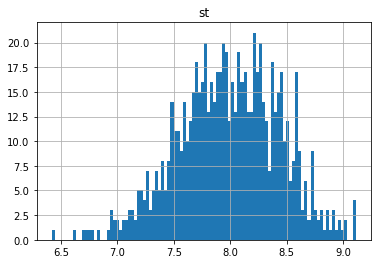

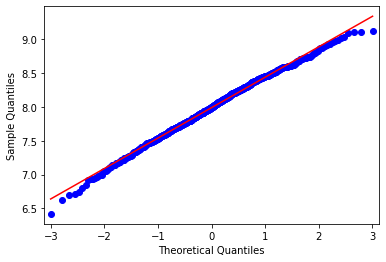

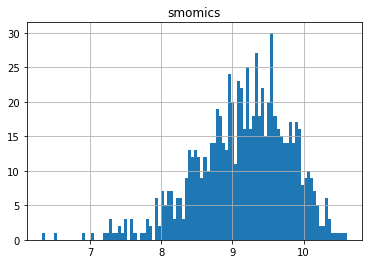

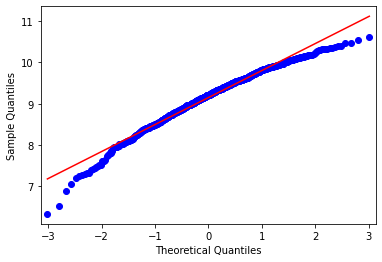

In [14]:
# Check for data distribution; if not normal - perform Wilcoxons later
#data collection and clean up 
ls_inside = ls_melt[ls_melt['variable'] == 'UMIs inside'].reset_index(drop=True)
ls = []
for i in ls_inside[ls_inside['Condition'] == 'ST']['value']:
    ls.append(i)
st = [item for sublist in ls for item in sublist]
ls = []
for i in ls_inside[ls_inside['Condition'] == 'sm-omics']['value']:
    ls.append(i)
smomics = [item for sublist in ls for item in sublist]
ls_inside = pd.DataFrame({'Condition':['st', 'smomics'], 'value':[st, smomics]})

#check with ks test
for i in ls_inside.index:
    
    # plot replicate visium umis
    a = np.log(ls_inside.iloc[i,:]['value'])
    a = a[~np.isinf(a)]
    #a = ls_inside.iloc[i,:]['value']
    #a = a[(a>a.mean()-3*a.std())&(a<a.mean()+3*a.std())]

    pd.DataFrame(a).hist(bins = 100)
    print(ls_inside.iloc[i,:]['Condition'])
    plt.title(ls_inside.iloc[i,:]['Condition'])
    print('variance: '+str(statistics.variance(a)))
    print('mean: '+str(np.mean(a)))
    # check for normal distribution 
    sm.qqplot(a, line='s')
    

    k2, p = stats.kstest(a, 'norm', args=(a.mean(), a.std()))#, 'norm', args=(a.mean(), a.std()))
    print("ks test p = {:g}".format(p))
    alpha = 0.001

    if p > alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected. Data is normal.")
    else:
        print("The null hypothesis cannot be rejected. Data is non-normal.")

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

['Genes inside', 'Genes outside'] ['ST', 'sm-omics']
Genes inside_sm-omics v.s. Genes inside_ST: Perm-test P_val=4.950e-02 
Genes outside_sm-omics v.s. Genes outside_ST: Perm-test P_val=2.564e-01 


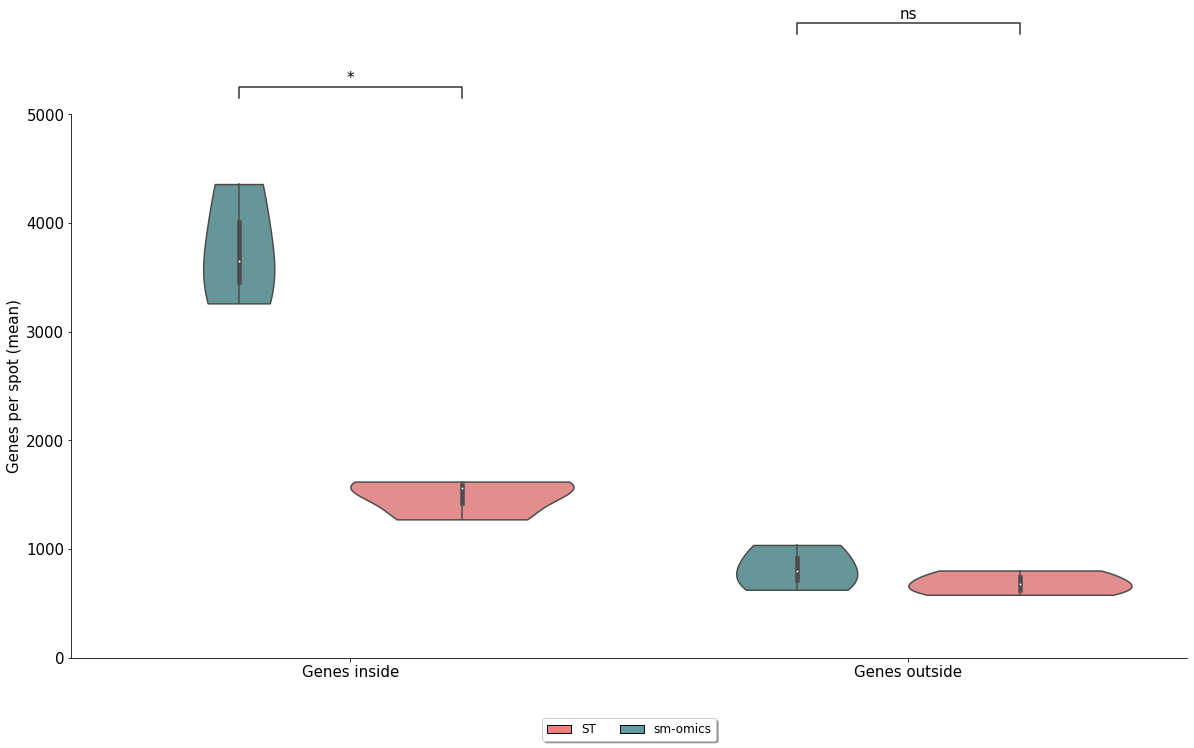

In [10]:
'Plots violin plots inside vs. outside tissue: Genes'
fig = plt.figure(figsize=(5, 5)) 

x='variable'
y='value'
hue = 'Condition'
data=dfplot

ax = sns.violinplot(x=x, y=y, data=data, hue=hue, hue_order = [ 'sm-omics','ST',], order = ['Genes inside', 'Genes outside'], palette = [ 'cadetblue','lightcoral',], cut=0)

# change background color and figure borders
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("Genes per spot (mean)", fontsize=15)
ax.set_ylim([0,5000])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

# Calculate Wilcoxons 
boxPairList = [(('Genes inside','sm-omics'), ('Genes inside','ST')),
               (('Genes outside','sm-omics'), ('Genes outside','ST'))]

add_stat_annotation(ax, data=data, x=x, y=y, hue=hue,
                    box_pairs=boxPairList,
                    test='Perm-test', text_format='star', loc='outside', verbose=2, fontsize=15)

# Add patterns to distinuigh boxes
# hatch= ['////']
# for i, thisviolin in enumerate(ax.get_children()):
#     if isinstance(thisviolin, mpl.collections.PolyCollection):
#         if i in [2, 6]:
#             thisviolin.set_hatch(hatch =hatch[0])
#             thisviolin.set_edgecolor('k')
            
# Legend
handles, labels = ax.get_legend_handles_labels()
labels2 = [ 'ST','sm-omics']
handles2 = handles[0:2]

inside_patch = mpatches.Patch( facecolor='lightcoral', label=labels2[0], edgecolor='k')
outside_patch= mpatches.Patch( facecolor='cadetblue',  label=labels2[1], edgecolor='k')
ax.legend(handles = [inside_patch, outside_patch],loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2, fontsize=12)


fig.set_size_inches(20, 10)
# plt.savefig("../../figures/SM_ST_Genes.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)

In [11]:
data.groupby(['Condition', 'variable']).mean().round()

value
Condition variable             
ST        Genes inside   1487.0
          Genes outside   686.0
sm-omics  Genes inside   3757.0
          Genes outside   821.0

In [12]:
data.groupby(['Condition', 'variable']).std().round()

value
Condition variable            
ST        Genes inside   186.0
          Genes outside  112.0
sm-omics  Genes inside   556.0
          Genes outside  207.0

In [13]:
arr = list(data[(data['Condition'] == 'ST') & (data['variable'] == 'Genes inside')]['value'])
mean = np.mean(arr)
sd = np.std(arr)

In [14]:
final_list = [x for x in arr if (x > mean - 2 * sd)]
print("within 2 stdevs: ", final_list)
final_list = [x for x in final_list if (x < mean + 2 * sd)]
print("within 2 stdevs: ", final_list)

within 2 stdevs:  [1621.021505376344, 1565.388888888889, 1273.9014778325122]
within 2 stdevs:  [1621.021505376344, 1565.388888888889, 1273.9014778325122]


['UMIs inside', 'UMIs outside'] ['ST', 'sm-omics']
UMIs inside_sm-omics v.s. UMIs inside_ST: Perm-test P_val=4.950e-02 
UMIs outside_sm-omics v.s. UMIs outside_ST: Perm-test P_val=1.007e-01 


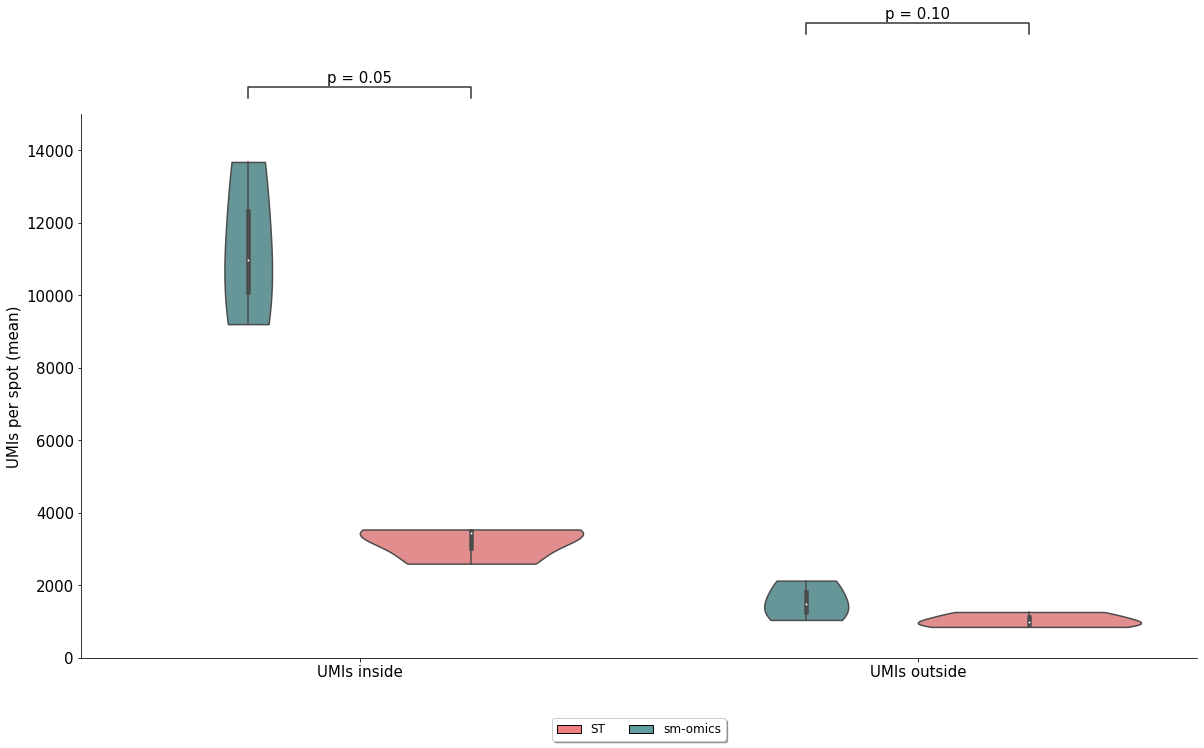

In [15]:
'Plots violin plots inside vs. outside tissue: Genes'
fig = plt.figure(figsize=(5, 5)) 

x='variable'
y='value'
hue = 'Condition'
data=dfplot_umi

ax = sns.violinplot(x=x, y=y, data=data, hue=hue, hue_order = [ 'sm-omics','ST',], order = ['UMIs inside', 'UMIs outside'], palette = [ 'cadetblue','lightcoral',], cut=0)

# change background color and figure borders
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("UMIs per spot (mean)", fontsize=15)
ax.set_ylim([0,15000])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

# Calculate Wilcoxons 
boxPairList = [(('UMIs inside','sm-omics'), ('UMIs inside','ST')),
               (('UMIs outside','sm-omics'), ('UMIs outside','ST'))]

add_stat_annotation(ax, data=data, x=x, y=y, hue=hue,
                    box_pairs=boxPairList,
                    test='Perm-test', text_format='simple', loc='outside', verbose=2, fontsize=15)

# Add patterns to distinuigh boxes
hatch= ['////']
# for i, thisviolin in enumerate(ax.get_children()):
#     if isinstance(thisviolin, mpl.collections.PolyCollection):
#         if i in [2, 6]:
#             thisviolin.set_hatch(hatch =hatch[0])
#             thisviolin.set_edgecolor('k')
            
# Legend
handles, labels = ax.get_legend_handles_labels()
labels2 = [ 'ST','sm-omics']
handles2 = handles[0:2]

inside_patch = mpatches.Patch( facecolor='lightcoral', label=labels2[0], edgecolor='k')
outside_patch = mpatches.Patch( facecolor='cadetblue',  label=labels2[1], edgecolor='k')
ax.legend(handles = [inside_patch, outside_patch],loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2, fontsize=12)


fig.set_size_inches(20, 10)
# plt.savefig("../../figures/SM_ST_UMIs.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)

In [16]:
data.groupby(['Condition', 'variable']).mean().round()

value
Condition variable             
ST        UMIs inside    3192.0
          UMIs outside   1039.0
sm-omics  UMIs inside   11287.0
          UMIs outside   1552.0

In [17]:
data.groupby(['Condition', 'variable']).std().round()

value
Condition variable            
ST        UMIs inside    515.0
          UMIs outside   208.0
sm-omics  UMIs inside   2254.0
          UMIs outside   545.0

In [18]:
arr = list(data[(data['Condition'] == 'sm-omics') & (data['variable'] == 'Genes inside')]['value'])
mean = np.mean(arr)
sd = np.std(arr)

final_list = [x for x in arr if (x > mean - 2 * sd)]
print("within 2 stdevs: ", final_list)
final_list = [x for x in final_list if (x < mean + 2 * sd)]
print("within 2 stdevs: ", final_list)

within 2 stdevs:  []
within 2 stdevs:  []


In [19]:
emb_genes = [27893,27256,26693,27379,25582]
emb_umis = [3978914,3462300,2911180,2975887,3274052,3412990]

In [20]:
100*np.std(emb_genes)/np.mean(emb_genes)

2.9223680540429164

In [21]:
100*np.std(emb_umis)/np.mean(emb_umis)

10.592887360335363

In [22]:
stahl_umis = [37400,45400,17900,38000,14200]

In [23]:
100*np.std(stahl_umis)/np.mean(stahl_umis)

40.058207973732245

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

['ST', 'sm-omics'] None
sm-omics v.s. ST: Perm-test P_val=4.950e-02 


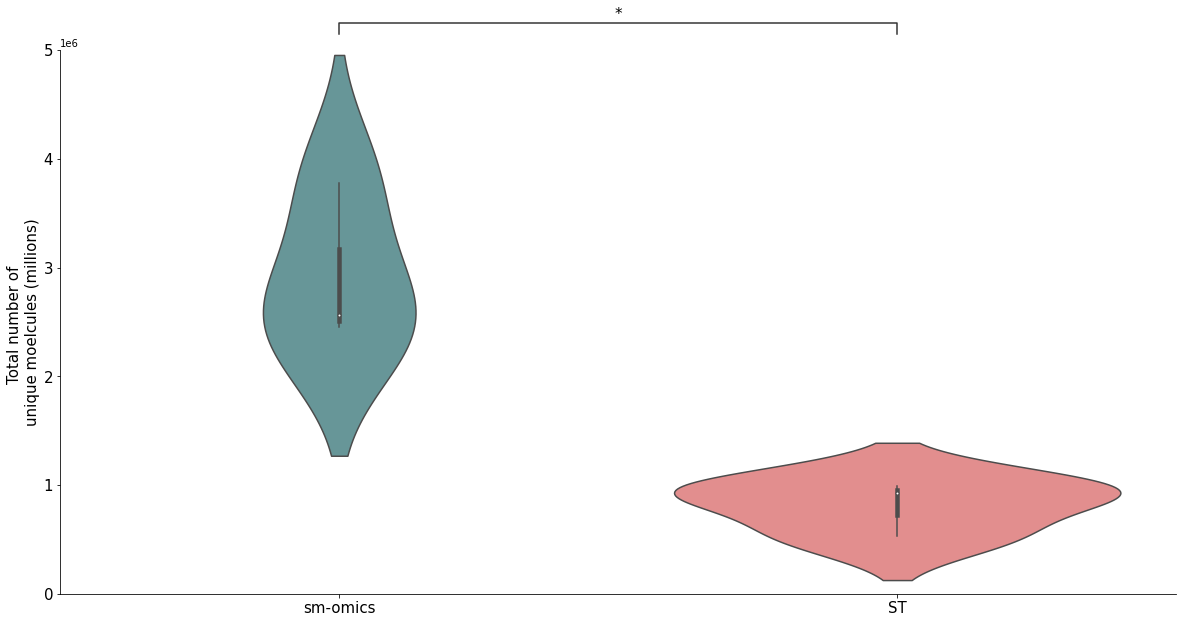

In [24]:
# Plot total UMI counts per condition
fig = plt.figure(figsize=(5, 5)) 

x='Condition'
y='value'
df_umi_total_inside = df_umi_total[df_umi_total['variable'] == "UMIs inside"]
data=df_umi_total_inside

ax = sns.violinplot(x=x, y=y, data=data, palette = ['cadetblue', 'lightcoral'], order = ['sm-omics', 'ST'])

# change background color
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("Total number of \nunique moelcules (millions)", fontsize=15)
ax.set_ylim([0,5000000])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_xticklabels(['sm-omics', 'ST'])

# # Separator on y axis
# ax.get_yaxis().set_major_formatter(
#     mpl.ticker.FuncFormatter(lambda x, p: format(float(x/1000000), ',')))

# Calculate T-test 
boxPairList = [(('sm-omics'), ('ST'))]

add_stat_annotation(ax, data=data, x=x, y=y,
                    box_pairs=boxPairList,
                    test='Perm-test', text_format='star', loc='outside', verbose=2, fontsize=15)

fig.set_size_inches(20, 10)
# plt.savefig("../../figures/SM_ST_Total_UMIs.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

['ST', 'sm-omics'] None
sm-omics v.s. ST: Perm-test P_val=4.950e-02 


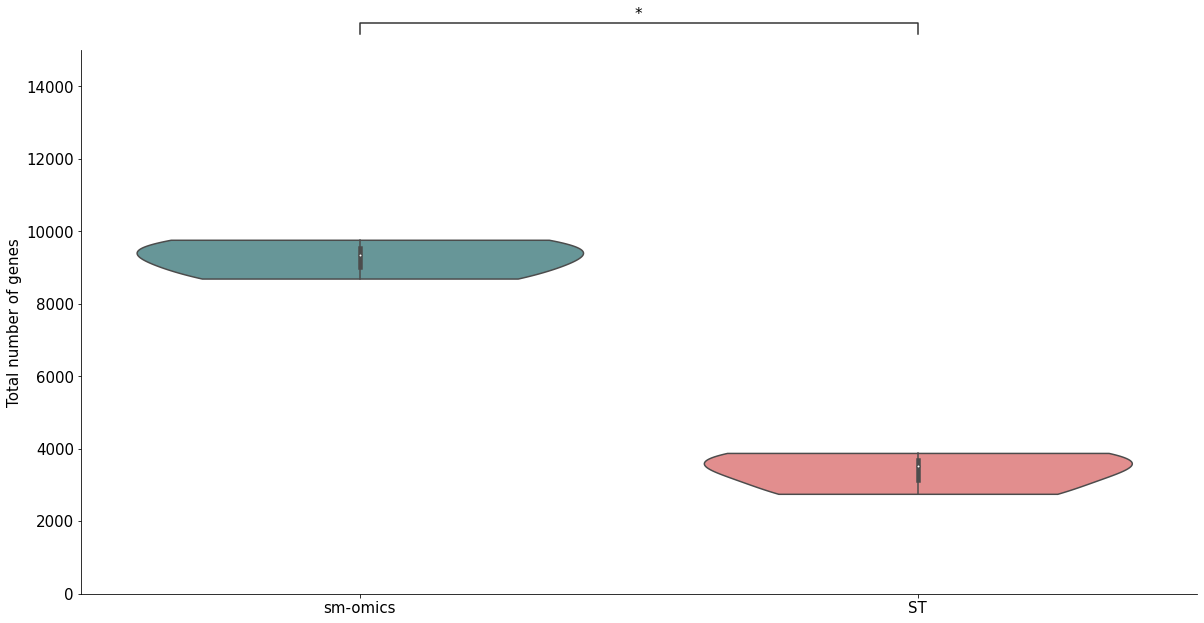

In [25]:
# Plot total genes per condition
fig = plt.figure(figsize=(5, 5)) 

x='Condition'
y='value'
df_genes_total_inside = df_genes_total[df_genes_total['variable'] == "Genes inside"]
data=df_genes_total_inside

ax = sns.violinplot(x=x, y=y, data=data, palette = ['cadetblue', 'lightcoral'], order = ['sm-omics', 'ST'], cut = 0)

# change background color
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("Total number of genes", fontsize=15)
ax.set_ylim([0,15000])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_xticklabels(['sm-omics', 'ST'])

# # Separator on y axis
# ax.get_yaxis().set_major_formatter(
#     mpl.ticker.FuncFormatter(lambda x, p: format(float(x/1000000), ',')))

# Calculate T-test 
boxPairList = [(('sm-omics'), ('ST'))]

add_stat_annotation(ax, data=data, x=x, y=y,
                    box_pairs=boxPairList,
                    test='Perm-test', text_format='star', loc='outside', verbose=2, fontsize=15)

fig.set_size_inches(20, 10)
# plt.savefig("../../figures/SM_ST_Total_Genes.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)

In [26]:
df_genes_total

,index,Condition,variable,value
0,10005CN48_C1,ST,Genes inside,3887
1,10005CN48_D1,ST,Genes inside,3524
2,10005CN48_E1,ST,Genes inside,2759
3,10015CN84_D2,sm-omics,Genes inside,9338
4,10015CN84_C2,sm-omics,Genes inside,8699
5,10015CN60_E2,sm-omics,Genes inside,9769
6,10005CN48_C1,ST,Genes outside,3090
7,10005CN48_D1,ST,Genes outside,3603
8,10005CN48_E1,ST,Genes outside,3344
9,10015CN84_D2,sm-omics,Genes outside,6483


In [27]:
df_umi_total_INSIDE = dfplot_umi[dfplot_umi['variable'] == 'UMIs inside']
df_umi_total_INSIDE.groupby(['Condition', 'variable',]).mean()

,,value
Condition,variable,
ST,UMIs inside,3191.598699
sm-omics,UMIs inside,11286.833486


In [28]:
df_umi_total_INSIDE = dfplot_umi[dfplot_umi['variable'] == 'UMIs inside']
df_umi_total_INSIDE.groupby(['Condition', 'variable',]).std()

,,value
Condition,variable,
ST,UMIs inside,515.308974
sm-omics,UMIs inside,2254.292215


In [29]:
100*df_umi_total_INSIDE.groupby(['Condition', 'variable',]).std()/df_umi_total_INSIDE.groupby(['Condition', 'variable',]).mean()

,,value
Condition,variable,
ST,UMIs inside,16.145795
sm-omics,UMIs inside,19.972760


In [30]:
df_umi_total_INSIDE = dfplot[dfplot['variable'] == 'Genes inside']
df_umi_total_INSIDE.groupby(['Condition', 'variable',]).mean()

,,value
Condition,variable,
ST,Genes inside,1486.770624
sm-omics,Genes inside,3756.986492


In [31]:
df_umi_total_INSIDE = dfplot[dfplot['variable'] == 'Genes inside']
df_umi_total_INSIDE.groupby(['Condition', 'variable',]).std()

,,value
Condition,variable,
ST,Genes inside,186.436858
sm-omics,Genes inside,555.986843


In [32]:
100*df_umi_total_INSIDE.groupby(['Condition', 'variable',]).std()/df_umi_total_INSIDE.groupby(['Condition', 'variable',]).mean()

,,value
Condition,variable,
ST,Genes inside,12.539719
sm-omics,Genes inside,14.798745
